# Deep learning の練習

* scikit-learn の iris データを例に、ai-chan で機械学習をする

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets

import sys,os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from ai_chan import dl
from ai_chan import math

# データの読み込み
* 1列が1つのデータセットになるように、読み込んだデータを転置する
* 機械学習の基本のキ → 教師データを学習用と、検証用に分ける

In [2]:
# データセットのロード
# iris.data = [(がく片の長さ , がく片の幅 , 花びらの長さ , 花びらの幅)]
iris = datasets.load_iris()
x_vals = np.array([x[0:3] for x in iris.data])
d_vals = np.array([x[3] for x in iris.data])

data_size = len(x_vals)
train_size = int(data_size * 0.8)
test_size = data_size - train_size

x_train = x_vals[0:train_size].T
d_train = d_vals[0:train_size].T

x_eval = x_vals[train_size:data_size].T
d_eval = d_vals[train_size:data_size].T

print ("total:{} = train:{} + test:{}".format(data_size, len(x_train[0]), len(x_eval[0])))

total:150 = train:120 + test:30


# 機械学習
* 学習率は、0.001
* 100 回学習を行う
* かなり急激に学習が進む

In [3]:
w, b = dl.create_network(3, 5, 5, 1, layer_factory = dl.create_layer_random)

# 訓練誤差
tx = []
te = []
# 汎化誤差
gx = []
ge = []

# 学習率
lr = 0.001

for cnt in range(0, 250):
    # 順伝搬 (評価用)
    gu, gz, gy = dl.forward(x_eval, w, b, math.relu, math.identity_mapping)

    # 誤差評価 (評価用)
    gx.append(cnt)
    error = math.least_square(d_eval, gy) / len(x_eval[0])
    ge.append(error)

    # 順伝搬 (訓練用)
    u, z, y = dl.forward(x_train, w, b, math.relu, math.identity_mapping)

    # 誤差評価 (訓練用)
    tx.append(cnt)
    te.append(math.least_square(d_train, y) / len(x_train[0]))

    # 逆伝搬
    dEdW, dEdB = dl.backward(w, b, u, z, y - d_train, math.d_relu)
    # パラメータ修正
    w, b = dl.adjust_network(w, b, dEdW, dEdB, learning_rate=lr)

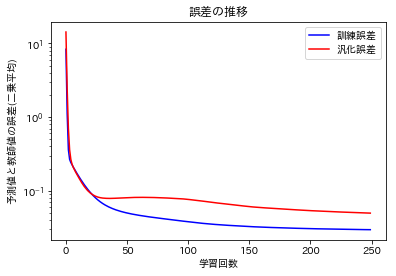

In [4]:
plt.figure()
plt.title("誤差の推移")
plt.xlabel("学習回数")
plt.ylabel("予測値と教師値の誤差(二乗平均)")

plt.yscale("log")
plt.plot(tx, te, color='blue', label='訓練誤差')
plt.plot(gx, ge, color='red', label='汎化誤差')
plt.legend()
plt.show()

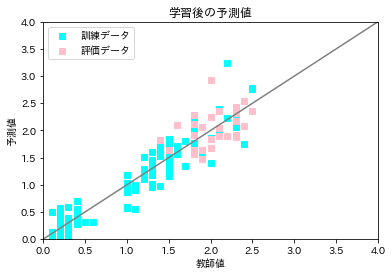

In [5]:
plt.figure()
plt.title("学習後の予測値")
plt.xlabel("教師値")
plt.ylabel("予測値")
plt.xlim(0.0, max(4.0, np.max(d_train), np.max(d_eval)))
plt.ylim(0.0, max(4.0, np.max(y), np.max(gy)))
plt.scatter(d_train.T, y.T, color="cyan", marker="s", label="訓練データ")
plt.scatter(d_eval.T, gy.T, color="pink", marker="s", label="評価データ")

x = np.arange(-10,10,0.1)
plt.plot(x, x, color="gray")
plt.legend()
plt.show()